# Bonus Exercise: Agent simulation on contagion spread

Karthik Jayadevan (5582876)

## Introduction

In this exercise a simulation is modelled on how an infectious disease spreads through a population, using a model where individuals are represented by moving particles, called *agents*.

- **Task I**: We start by implementing particles to act as individuals who can be *healthy*, *infected*, or *immunized* against an infection.

- **Task II**: These particles are then set in motion within a box with no PBC, observing how they collide and potentially spread the infection over time.

- **Task III**: Lastly, we analyze the outcomes to see how different levels of immunization in the population affect the spread of the disease.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from tqdm import tqdm
import matplotlib.patches as mpatches

plt.style.use('ggplot')
plt.style.use('../../ccs_ex.mplstyle')

## Task I: Implementation

The `Particle` class is updated to include three additional attributes: `state`, `steps_infected` and `infected_this_step`.

- `state`: (a string) to note whether a given particle is healthy, infected or immunized.
- `steps_infected`: (an integer) to keep track of the number of steps since the particle has been infected. This is important since the task specifies a condtion that an infected particle gets immunized after 500 steps.
- `infected_this_step`: (a Boolean) This is an additional parameter restriction introduced in addition of the exercise requirements. This property was introduced because, in its absence, the contagion spread was too rapid, and as a result, all particles were immunized within about 1000 steps of the 10,000 step simulation run. To prevent this, I introduce a restriction that an infected particle can only infect one other uninfected particle in a single time step. This gives more physical results.

In [5]:
class Particle:
    def __init__(self, x, y, vx, vy, radius=0.5, state='healthy'):
        self.x = x
        self.y = y
        self.vx = vx
        self.vy = vy
        self.radius = radius
        self.state = state # healthy, infected or immunized
        self.steps_infected = 0 # number of steps infected
        self.infected_this_step = False  # Tracks if the particle has infected another particle this step

    def update_state(self):
        '''to update the states of particles'''
        if self.state == 'infected':
            self.steps_infected += 1
            if self.steps_infected >= 500:
                self.state = 'immunized'
                self.steps_infected = 0  # Reset the counter


The `initialize_particles` function prepares the initial setup of our particle simulation. It calculates the number of immunized particles from the specified immunization rate and generates each particle with a random position and velocity. After initializing the majority as healthy, it randomly selects one particle to be infected, introducing the contagion into the system.

In [6]:
def initialize_particles(num_particles, immunized_percentage, box_size):
    '''sets the initial positions and states of the agents'''
    particles = []
    immunized_count = int(num_particles * immunized_percentage / 100)
    
    # Initialize particles
    for _ in range(num_particles):
        x, y = np.random.uniform(0, box_size, 2)
        vx, vy = np.random.uniform(-0.5, 0.5, 2)
        state = 'healthy'
        if len(particles) < immunized_count:
            state = 'immunized'
        particles.append(Particle(x, y, vx, vy, state=state))

    # Infect one random particle
    particles[np.random.randint(num_particles)].state = 'infected'

    return particles

The `elastic_collision` and `update_positions` functions from the previous exercises of the hard-sphere model are reused here:

In [7]:
def elastic_collision(p1, p2):
    # packing the positions and velocities as vectors:
    r1, r2 = np.array([p1.x, p1.y]), np.array([p2.x, p2.y])
    v1, v2 = np.array([p1.vx, p1.vy]), np.array([p2.vx, p2.vy])

    d = np.linalg.norm(r1 - r2)**2
    
    # the final velocities as per the formula
    u1 = v1 - np.dot(v1 - v2, r1 - r2) / d * (r1 - r2)
    u2 = v2 - np.dot(v2 - v1, r2 - r1) / d * (r2 - r1)

    # unpacking the final velocity vector:
    p1.vx, p1.vy = u1
    p2.vx, p2.vy = u2

    return p1, p2

In [8]:
def update_positions(particles, box_size,timestep=1):    
    # Update the position of each particle based on its velocity
    for p in particles:
        p.x += p.vx*timestep
        p.y += p.vy*timestep

        # Reflective boundaries
        if p.x < 0 or p.x > box_size:
            p.vx *= -1  # Reverse x velocity
            p.x = max(0, min(p.x, box_size))  # Keep within bounds

        if p.y < 0 or p.y > box_size:
            p.vy *= -1  # Reverse y velocity
            p.y = max(0, min(p.y, box_size))  # Keep within bounds

The function `check_and_handle_collisions` manages interactions between particles. It iterates over pairs of particles, determining if they collide based on their radii and positions (similar to the collision functions in the previous exercises). 

- Additionally, when a collision is detected, it adjusts their positions to resolve the overlap and updates the velocities using equations of elastic collisions of identical masses.

- This function also includes the contagion dynamics, allowing infected particles:
  - to transmit the infection to healthy ones or, 
  - with a probability of 20% (changed later), to immunized particles.

In [9]:
def check_and_handle_collisions(particles):
    """checks for collisions and updates states on collision"""
    
    num_particles = len(particles)
    for i in range(num_particles):
        for j in range(i + 1, num_particles):
            p1, p2 = particles[i], particles[j]

            # Reset infection flag at the start of each step
            p1.infected_this_step = p2.infected_this_step = False

            dx, dy = p1.x - p2.x, p1.y - p2.y
            distance = np.sqrt(dx**2 + dy**2)

            overlap = p1.radius + p2.radius - distance

            # Check for collision
            if overlap > 0:
                # Separate the particles to ensure they are no longer overlapping
                separation = overlap / 2
                unit_vector = np.array([dx, dy]) / distance
                p1.x += unit_vector[0] * separation
                p1.y += unit_vector[1] * separation
                p2.x -= unit_vector[0] * separation
                p2.y -= unit_vector[1] * separation

                # Handle collision with elastic collision physics
                p1, p2 = elastic_collision(p1, p2)

                # Contagion spread logic
                if p1.state == 'infected' and not p1.infected_this_step:
                    if p2.state == 'healthy':
                        p2.state = 'infected'
                        p1.infected_this_step = True
                    elif p2.state == 'immunized' and np.random.uniform(0, 1) <= 0.2:
                        p2.state = 'infected'
                        p1.infected_this_step = True
                elif p2.state == 'infected' and not p2.infected_this_step:
                    if p1.state == 'healthy':
                        p1.state = 'infected'
                        p2.infected_this_step = True
                    elif p1.state == 'immunized' and np.random.uniform(0, 1) <= 0.2:
                        p1.state = 'infected'
                        p2.infected_this_step = True

The `run_simulation` function is used to run the entire simulation process. 
- It initializes the particles with the given immunization percentage and then runs the simulation for the specified number of steps. 
- At each step, it updates the positions of the particles, checks for and handles collisions, and updates the state of each particle (tracking infection and immunization status). 
- The function keeps a record of both the trajectory and the state of each particle throughout the simulation, which are essential for analysis later.

In [10]:
def run_simulation(num_particles, immunized_percentage, box_size, num_steps):
    # Initialize particles within the function
    particles = initialize_particles(num_particles, immunized_percentage, box_size)

    # to store the trajectory of each particle at each step
    # Shape: (num_steps, num_particles, 2) for (x, y) pairs
    trajectory_data = np.zeros((num_steps, num_particles, 2))

    # to store the state of each particle at each step
    state_data = np.zeros((num_steps, num_particles), dtype=object)

    for step in tqdm(range(num_steps)):
        # Update positions and check for collisions
        update_positions(particles, box_size)
        check_and_handle_collisions(particles)

        # Update the state of each particle
        for p in particles:
            p.update_state()

        # Store the position data
        for i, p in enumerate(particles):
            trajectory_data[step, i] = [p.x, p.y]
            state_data[step, i] = p.state

    return trajectory_data, state_data

## Task II: Simulation

In [11]:
# Parameters for the simulation
num_particles = 50  # Number of particles
immunized_percentage = 20  # Percentage of immunized particles
box_size = 50  # Size of the simulation box
num_steps = 10_000  # Number of steps in the simulation

# Running the simulation
trajectory_data, state_data = run_simulation(num_particles, immunized_percentage, box_size, num_steps)


100%|██████████| 10000/10000 [00:42<00:00, 236.75it/s]


The `visualize_stages` function is designed to plot the progression of the contagion spread at different stages of the simulation. Since this is not directly a task, I use ChatGPT to generate some parts of this function to enhance the visibility of the plot by adding extra legends. 

Color code:
- **healthy**: green
- **infected**: red
- **immunized**: blue

In [12]:
def visualize_stages(trajectory_data, state_data, box_size, stages, num_steps):
    fig, axs = plt.subplots(1, len(stages), figsize=(20, 6))

    # Define colors for different states
    colors = {'healthy': 'green', 'infected': 'red', 'immunized': 'blue'}
    legend_handles = [mpatches.Patch(color=color, label=state) for state, color in colors.items()]

    for i, stage in enumerate(stages):
        ax = axs[i]
        state_counts = {'healthy': 0, 'infected': 0, 'immunized': 0}

        for j, p_data in enumerate(trajectory_data[stage]):
            state = state_data[stage][j]
            ax.scatter(p_data[0], p_data[1], color=colors[state])
            state_counts[state] += 1

        ax.set_xlim(0, box_size)
        ax.set_ylim(0, box_size)
        ax.set_title(fr'Step: {stage+1:,}')
        ax.grid(True)

        # Add state counts to each subplot
        count_text = f'Healthy: {state_counts["healthy"]}\n' + \
                    f'Infected: {state_counts["infected"]}\n' + \
                    f'Immunized: {state_counts["immunized"]}'
        ax.text(0.05, 0.95, count_text, transform=ax.transAxes, fontsize=9, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    fig.suptitle('Health Status Comparison')
    fig.legend(handles=legend_handles, loc='upper right')
    plt.tight_layout()
    plt.show()

    return fig


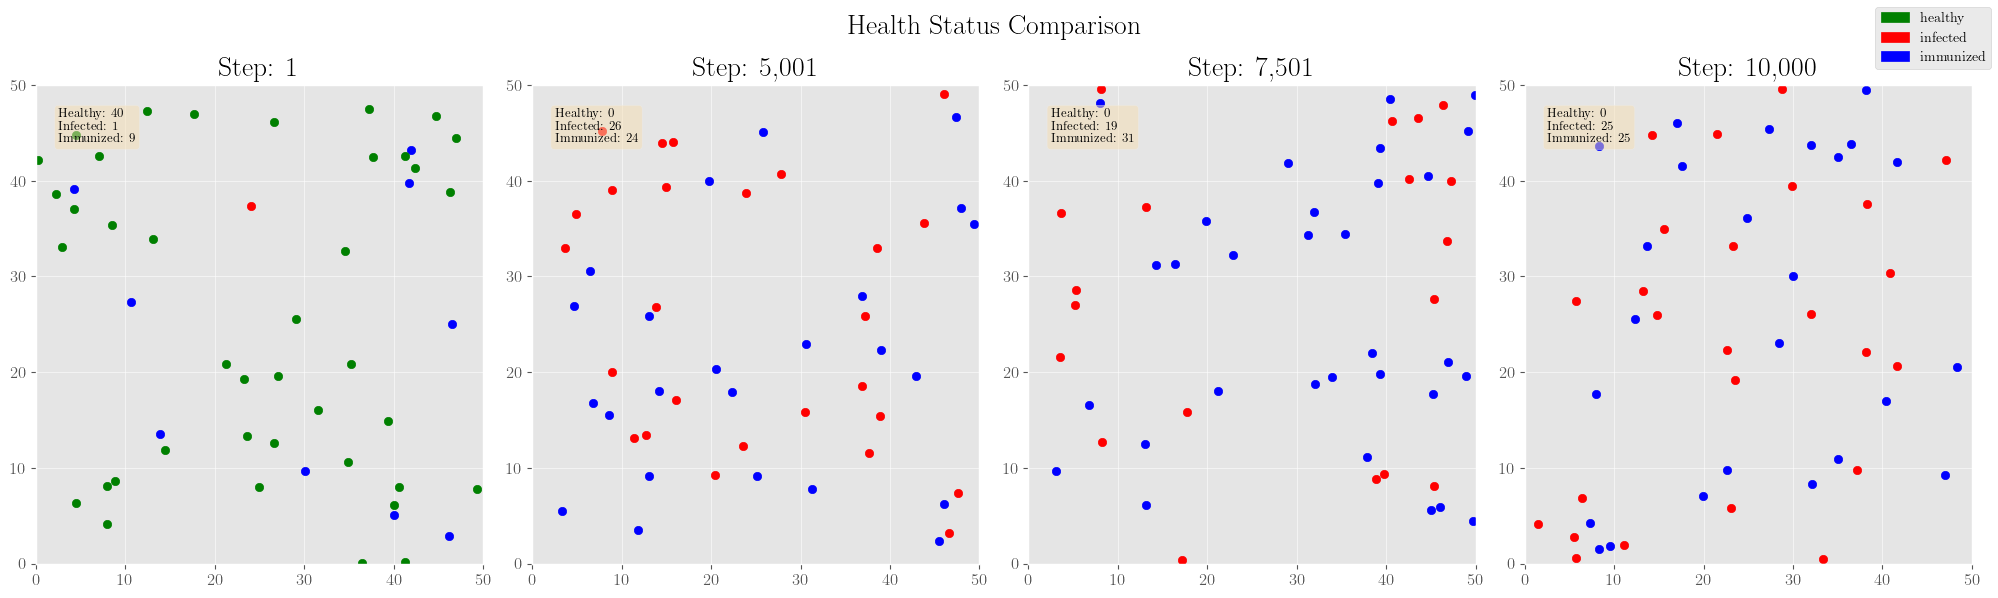

<Figure size 640x480 with 0 Axes>

In [18]:
# visualization at different stages
stages = [0, len(state_data)//2, 3*len(state_data)//4,  len(state_data) - 1]
fig = visualize_stages(trajectory_data, state_data, box_size, stages,num_steps=num_steps);
plt.savefig(f'Health_state_status_{immunized_percentage}.png')

Animation functions `init` and `animate` are initialized similar to the previous exercises. The `animate` function is modified to use different colors corresponding to the state of the agent.

In [14]:
# Define the initial function for the animation
def init():
    for dot in dots:
        dot.set_data([], [])
    return dots

# Define the animate function for the animation
def animate(i):
    for j, dot in enumerate(dots):
        x = trajectory_data[i, j, 0]
        y = trajectory_data[i, j, 1]
        dot.set_data(x, y)
        dot.set_color(colors[state_data[i][j]])
    return dots

In [15]:
# Initialize the figure and dots
fig, ax = plt.subplots()
dots = [ax.plot([], [], 'o')[0] for _ in range(num_particles)]

# Set the axis limits
ax.set_xlim(0, box_size)
ax.set_ylim(0, box_size)

# Create the animation object
anim = FuncAnimation(fig, animate, init_func=init, frames=num_steps, interval=20, blit=True)

plt.close(fig)
colors = {'healthy': 'green', 'infected': 'red', 'immunized': 'blue'}

HTML(anim.to_html5_video())

RuntimeError: x must be a sequence

The task II asks to run the simulations once with all particles moving, and once each where 20%, 50%, 80% and 90% are immunized. To do this more efficiently, a function `run_simulations_multi` is defined. A `print` statement is included to indicate which simulation is being run. The results are stored in the variable `simulation_results`.

In [16]:
def run_simulations_multi(num_steps=10_000):
    num_particles = 50
    box_size = 50
    immunization_rates = [20, 50, 80, 90]  # Percentages of immunization

    results = {}

    for rate in immunization_rates:
        print(f"Running simulation with {rate}% immunization rate")
        trajectory_data, state_data = run_simulation(num_particles, rate, box_size, num_steps)
        results[rate] = (trajectory_data, state_data)
    
    return results

In [17]:
# Run the simulations
simulation_results = run_simulations_multi(num_steps=10_000)

Running simulation with 20% immunization rate


100%|██████████| 10000/10000 [00:33<00:00, 301.49it/s]


Running simulation with 50% immunization rate


100%|██████████| 10000/10000 [00:35<00:00, 285.39it/s]


Running simulation with 80% immunization rate


100%|██████████| 10000/10000 [00:34<00:00, 286.94it/s]


Running simulation with 90% immunization rate


100%|██████████| 10000/10000 [00:31<00:00, 316.84it/s]


## Task III: Data evaluation of positions

The `plot_infection_curves` function plots the progression of infections over time for different initial immunization rates. It calculates the number of infected particles at each timestep for each immunization rate from the tuples stored in `simulation_results`. A plot of the number of infected agents over timesteps is plotted.

In [20]:
def plot_infection_curves(simulation_results, num_steps):
    plt.figure(figsize=(12, 8))

    for rate, (trajectory_data, state_data) in simulation_results.items():
        # Count the number of infected particles at each step
        infected_counts = [np.sum(states == 'infected') for states in state_data]

        # Plot the curve for this immunization rate
        plt.plot(range(num_steps), infected_counts, label=fr'{rate}$\%$')

    plt.title('Number of Infected Particles Over Time for Different Immunization Rates')
    plt.xlabel('Time Step')
    plt.ylabel('Number of Infected Particles')
    plt.legend(title='Initial immunized population',facecolor='white')
    plt.grid(True)
    plt.show()


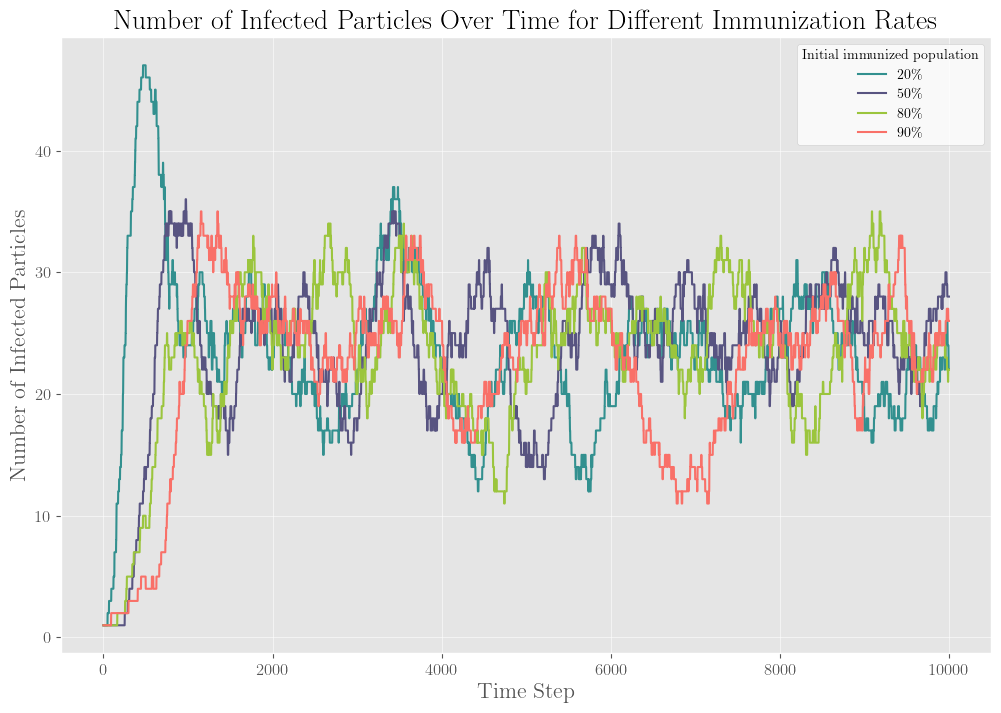

In [21]:
# Plot the curves using the simulation results
plot_infection_curves(simulation_results, num_steps=10_000)


**Observations**

- The curve with the lowest initial immunization rate (20%) shows the highest peaks, suggesting that a smaller vaccinated population isn't sufficient to significantly lower the spread of the virus.

- The curve for the immunization rate of 50% shows that the initial peak is lowered with a higher initially immunized population.

- Between the curves plotted, the initial peak can be seen to be delayed with increasing initial immunization rates. 

- The higher immunization rates also show significantly lowered initial peaks and the curve tends to flatten out better than the other two cases.

- In general, as the percentage of the vaccinated population increases, the peak of the infection curve becomes lower and the curves flatten out more.

- Since none of the simulations show the eradication of the contagion within 10,000 steps, it suggests an endemic situation rather than eradication even when the simulation starts with a 90% immunized population.

## Changing breakthrough-infection percentage

The previous functions are rewritten to include an additional argument to tweak the percentage of *breakthrough infections*, which we initially set as 20%.

In [22]:
def check_and_handle_collisions(particles,breakthrough=0.2):
    num_particles = len(particles)
    for i in range(num_particles):
        for j in range(i + 1, num_particles):
            p1, p2 = particles[i], particles[j]

            # Reset infection flag at the start of each step
            p1.infected_this_step = p2.infected_this_step = False

            dx, dy = p1.x - p2.x, p1.y - p2.y
            distance = np.sqrt(dx**2 + dy**2)

            overlap = p1.radius + p2.radius - distance

            # Check for collision
            if overlap > 0:
                # Separate the particles to ensure they are no longer overlapping
                separation = overlap / 2
                unit_vector = np.array([dx, dy]) / distance
                p1.x += unit_vector[0] * separation
                p1.y += unit_vector[1] * separation
                p2.x -= unit_vector[0] * separation
                p2.y -= unit_vector[1] * separation

                # Handle collision with elastic collision physics
                p1, p2 = elastic_collision(p1, p2)

                # Contagion spread logic
                if p1.state == 'infected' and not p1.infected_this_step:
                    if p2.state == 'healthy':
                        p2.state = 'infected'
                        p1.infected_this_step = True
                    elif p2.state == 'immunized' and np.random.uniform(0, 1) <= breakthrough:
                        p2.state = 'infected'
                        p1.infected_this_step = True
                elif p2.state == 'infected' and not p2.infected_this_step:
                    if p1.state == 'healthy':
                        p1.state = 'infected'
                        p2.infected_this_step = True
                    elif p1.state == 'immunized' and np.random.uniform(0, 1) <= breakthrough:
                        p1.state = 'infected'
                        p2.infected_this_step = True

In [23]:
def run_simulation(num_particles, immunized_percentage, box_size, num_steps,breakthrough=0.2):
    particles = initialize_particles(num_particles, immunized_percentage, box_size)
    trajectory_data = np.zeros((num_steps, num_particles, 2))
    state_data = np.zeros((num_steps, num_particles), dtype=object)

    for step in tqdm(range(num_steps)):
        update_positions(particles, box_size)
        check_and_handle_collisions(particles,breakthrough=breakthrough)
        for p in particles:
            p.update_state()
        for i, p in enumerate(particles):
            trajectory_data[step, i] = [p.x, p.y]
            state_data[step, i] = p.state

    return trajectory_data, state_data

In [24]:
def run_simulations_multi(num_steps=10_000,breakthrough=0.2):
    num_particles = 50
    box_size = 50
    immunization_rates = [20, 50, 80, 90]  # Percentages of immunization

    results = {}

    for rate in immunization_rates:
        print(f"Running simulation with {rate}% immunization rate")
        trajectory_data, state_data = run_simulation(num_particles, rate, box_size, num_steps,breakthrough=breakthrough)
        results[rate] = (trajectory_data, state_data)
    
    return results

In [26]:
def plot_infection_curves(simulation_results, num_steps,bk=0.1):
    plt.figure(figsize=(12, 8))

    for rate, (trajectory_data, state_data) in simulation_results.items():
        # Count the number of infected particles at each step
        infected_counts = [np.sum(states == 'infected') for states in state_data]

        # Plot the curve for this immunization rate
        plt.plot(range(num_steps), infected_counts, label=fr'{rate}$\%$')

    plt.title(fr'Breakthrough infection: {bk*100:.0f}$\%$')
    plt.xlabel('Time Step')
    plt.ylabel('Number of Infected Particles')
    plt.legend(title='Initial immunized population',facecolor='white')
    plt.grid(True)
    plt.show()


First we try lowering the percentage to 10% to see if this eradicates the infection from the population.

Running simulation with 20% immunization rate


100%|██████████| 10000/10000 [00:32<00:00, 303.26it/s]


Running simulation with 50% immunization rate


100%|██████████| 10000/10000 [00:28<00:00, 346.11it/s]


Running simulation with 80% immunization rate


100%|██████████| 10000/10000 [00:29<00:00, 339.23it/s]


Running simulation with 90% immunization rate


100%|██████████| 10000/10000 [00:29<00:00, 340.22it/s]


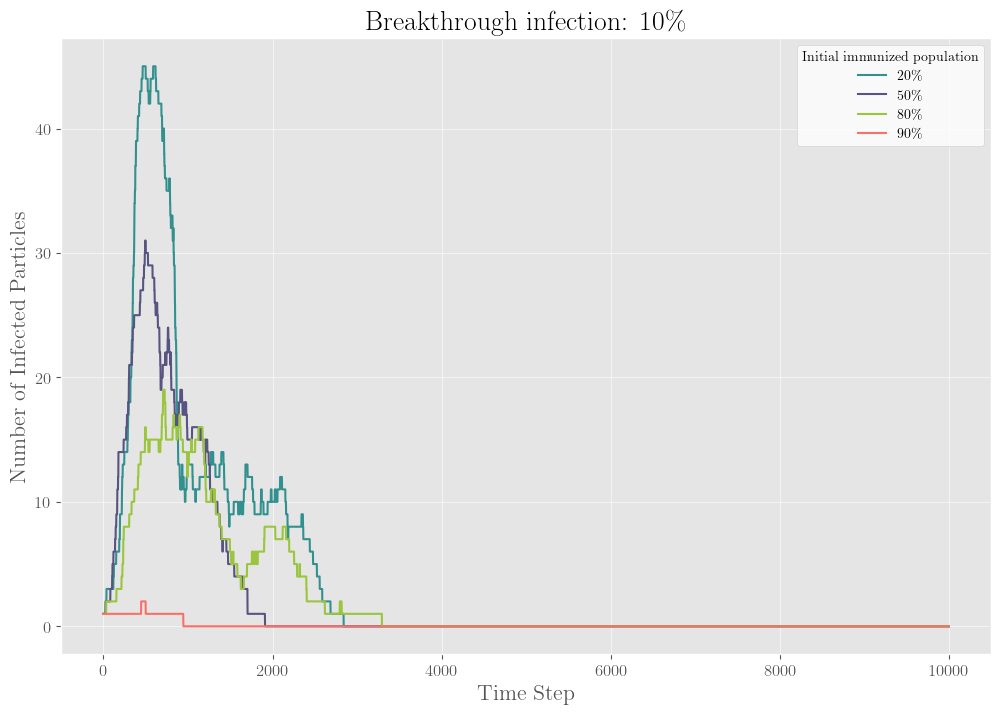

In [27]:
breakthrough_percent = 0.1

# Run the simulations
simulation_results = run_simulations_multi(num_steps=10_000,breakthrough=breakthrough_percent)

# Plot the curves using the simulation results
plot_infection_curves(simulation_results, num_steps=10_000,bk=breakthrough_percent)

We see that the infection is eradicated from the population at all initial immunized population percentages. With a 90% initially immunized population, the contagion barely gets a chance to spread. This indicates the significance of the efficacy of the vaccine employed.

Running simulation with 20% immunization rate


100%|██████████| 10000/10000 [00:31<00:00, 313.64it/s]


Running simulation with 50% immunization rate


100%|██████████| 10000/10000 [00:30<00:00, 326.74it/s]


Running simulation with 80% immunization rate


100%|██████████| 10000/10000 [00:31<00:00, 322.15it/s]


Running simulation with 90% immunization rate


100%|██████████| 10000/10000 [00:31<00:00, 320.73it/s]


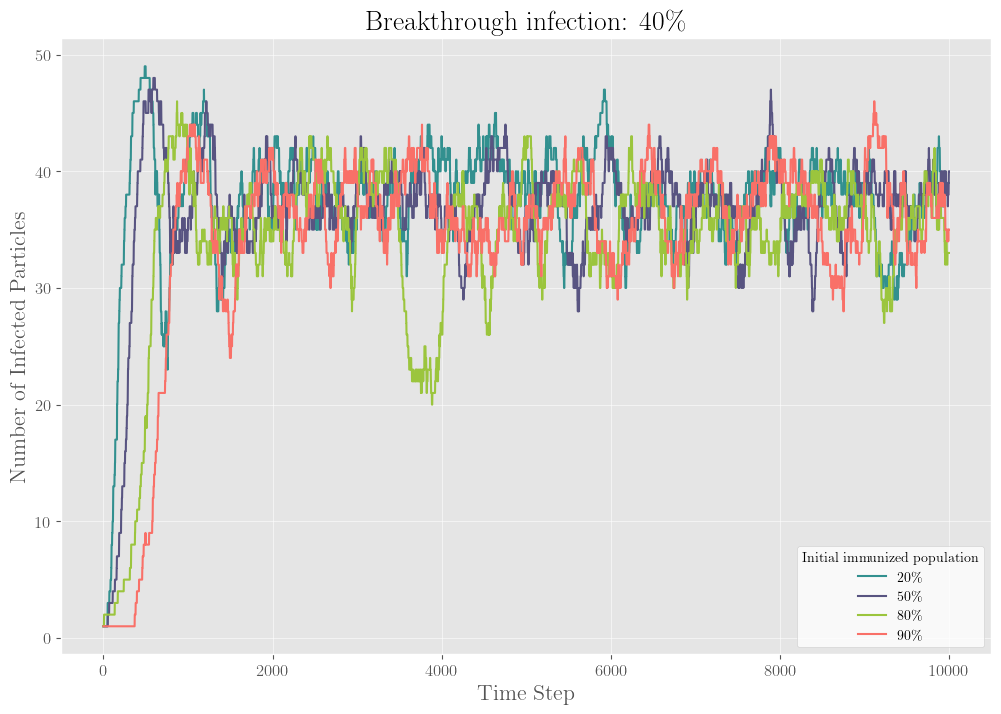

In [28]:
breakthrough_percent = 0.4

# Run the simulations
simulation_results = run_simulations_multi(num_steps=10_000,breakthrough=breakthrough_percent)

# Plot the curves using the simulation results
plot_infection_curves(simulation_results, num_steps=10_000,bk=breakthrough_percent)

When the breakthrough percentage is increased, the disease shows no signs of flattening in 10,000 time steps. An interesting observation is that for the case of 20% initial immunization, the curvetends to flatten between 4,000 and 6,000 steps, but then starts to fluctuate much more rapidly. 

In the cases of higher initial immunization percentages, the initial peak is delayed and slightly less in height compared to the other cases, just like we saw in the breakthrough percentage of 20% (in task III).